In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch import Tensor
from torch.nn import Module
from torch.nn.parameter import Parameter

from boundary import plot_decision_boundary
from gaussians import n_gaussians

## Data set

First we generate a toy data set for binary classification. We generate instances
around a middle point with a gaussian distribution.

In [2]:
X_train, Y_train = n_gaussians(np.array([[0.8, 0.2],[0.2, 0.8]]),
                               np.array([0, 1], dtype=np.float32), 200, stddev=0.3)
X_train = torch.tensor(X_train, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.int64)

X_validate, Y_validate = n_gaussians(np.array([[0.8, 0.2],[0.2, 0.8]]),
                                     np.array([0, 1], dtype=np.float32), 200, stddev=0.3)

Let's plot the the training instances to get a better idea of the distribution
of the data.

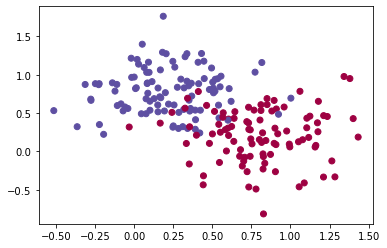

In [3]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=plt.cm.Spectral)

We will create a simple linear classifier without a probabilistic interpretation.
The normal outputs are just the raw outputs of $\mathbf{w}\cdot\mathbf{x} + b$.
Classification is performed by checking on which side of the boundary data points are.

In [4]:
class SimpleLinear(torch.nn.Module):
    def __init__(self, n_features: int):
        super(SimpleLinear, self).__init__()
        # The `Parameter` class wraps the parameters and registers them
        # so that we can e.g. get them through the `parameters` method
        # of module.
        self.weights = Parameter(torch.randn(n_features))
        self.bias = Parameter(torch.randn(()))
        
    def classify(self, x: Tensor) -> Tensor:
        activation = self.forward(x)
        return torch.where(activation < 0, 0, 1)
    
    def forward(self, x: Tensor) -> Tensor:
        # Note that we flip `w` and `x` here. The reason is that `x` is
        # not a single instance, but can be multiple instances and is
        # therefore laid out as a matrix `[n_instances, 2]`. The `@`
        # operator requires that last dimension of the first operand
        # is the same as the second dimension of the second operand.
        # We will discuss why this is the case in the lecture on matrix
        # multiplication.
        return x @ self.weights + self.bias

Such a linear classifier can be trained with [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss).

In [5]:
class HingeLoss(torch.nn.Module):
    def forward(self, predictions: Tensor, targets: Tensor):
        targets = targets.clone()
        targets[targets == 0] = -1
        return (1.0 - targets * predictions).maximum(torch.tensor(0.)).mean()
        

In [6]:
model = SimpleLinear(X_train.shape[1])
loss_function = HingeLoss()

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [8]:
for step in range(100):
    optimizer.zero_grad()
    loss = loss_function(model(X_train), Y_train)    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        acc = model.classify(X_train).eq(Y_train).to(torch.float).mean()

    print(f"Step: {step}, loss: {loss}, acc: {acc}")


Step: 0, loss: 1.1413859128952026, acc: 0.5049999952316284
Step: 1, loss: 0.9792688488960266, acc: 0.5199999809265137
Step: 2, loss: 0.867043673992157, acc: 0.5799999833106995
Step: 3, loss: 0.777549147605896, acc: 0.7049999833106995
Step: 4, loss: 0.6994391083717346, acc: 0.7799999713897705
Step: 5, loss: 0.6255579590797424, acc: 0.8450000286102295
Step: 6, loss: 0.5547879934310913, acc: 0.8999999761581421
Step: 7, loss: 0.49479836225509644, acc: 0.9100000262260437
Step: 8, loss: 0.44928500056266785, acc: 0.9100000262260437
Step: 9, loss: 0.4194104075431824, acc: 0.9100000262260437
Step: 10, loss: 0.3978830575942993, acc: 0.9150000214576721
Step: 11, loss: 0.3807849586009979, acc: 0.9150000214576721
Step: 12, loss: 0.36628028750419617, acc: 0.9200000166893005
Step: 13, loss: 0.35481640696525574, acc: 0.9200000166893005
Step: 14, loss: 0.34533941745758057, acc: 0.925000011920929
Step: 15, loss: 0.3359684646129608, acc: 0.9300000071525574
Step: 16, loss: 0.3276357352733612, acc: 0.93000

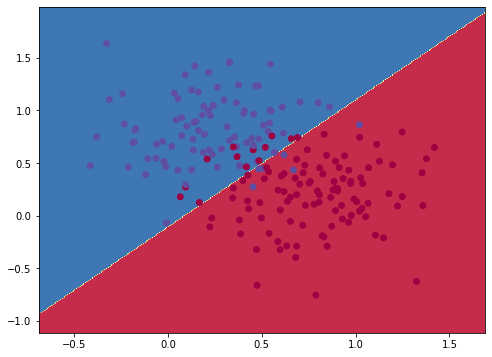

In [9]:
fig = plt.figure(figsize=(8, 6))
sub = fig.add_subplot(111)

def classify(x):
    x = torch.tensor(x, dtype=torch.float)
    return model.classify(x).detach().numpy()

plot_decision_boundary(sub, lambda x: classify(x), X_validate, Y_validate,
                           batch_size = X_validate.shape[0],
                           x_range = (X_validate[:,0].min(), X_validate[:,0].max()),
                           y_range = (X_validate[:,1].min(), X_validate[:,1].max()))